---
title: "Planning with Uncertainty (Part2 - Reinforcement Learning)"
format: html
page-layout: full
code-line-numbers: true
code-block-border: true
toc: true
toc-location: left
number-sections: true
jupyter: python3
---

# Representing Agents and Environments

In [1]:
import random
import math
import matplotlib.pyplot as plt

In [2]:
def flip(prob):
    """return true with probability prob"""
    return random.random() < prob

def argmaxall(gen):
    """gen is a generator of (element,value) pairs, where value is a real.
    argmaxall returns a list of all of the elements with maximal value.
    """
    maxv = -math.inf       # negative infinity
    maxvals = []      # list of maximal elements
    for (e,v) in gen:
        if v>maxv:
            maxvals,maxv = [e], v
        elif v==maxv:
            maxvals.append(e)
    return maxvals

def argmaxe(gen):
    """gen is a generator of (element,value) pairs, where value is a real.
    argmaxe returns an element with maximal value.
    If there are multiple elements with the max value, one is returned at random.
    """
    return random.choice(argmaxall(gen))

def argmax(lst):
    """returns maximum index in a list"""
    return argmaxe(enumerate(lst))

def argmaxd(dct):
   """returns the arg max of a dictionary dct"""
   return argmaxe(dct.items())

def select_from_dist(item_prob_dist):
    """ returns a value from a distribution.
    item_prob_dist is an item:probability dictionary, where the
        probabilities sum to 1.
    returns an item chosen in proportion to its probability
    """
    ranreal = random.random()
    for (it,prob) in item_prob_dist.items():
        if ranreal < prob:
            return it
        else:
            ranreal -= prob
    raise RuntimeError(f"{item_prob_dist} is not a probability distribution")


In [3]:
class Displayable(object):
    """Class that uses 'display'.
    The amount of detail is controlled by max_display_level
    """
    max_display_level = 1   # can be overridden in subclasses or instances

    def display(self,level,*args,**nargs):
        """print the arguments if level is less than or equal to the
        current max_display_level.
        level is an integer.
        the other arguments are whatever arguments print can take.
        """
        if level <= self.max_display_level:
            print(*args, **nargs) 

In [4]:
class Agent(Displayable):

    def initial_action(self, percept):
        """return the initial action."""
        return self.select_action(percept)   # same as select_action

    def select_action(self, percept):
        """return the next action (and update internal state) given percept
        percept is variable:value dictionary
        """
        raise NotImplementedError("go")   # abstract method

In [5]:
class Environment(Displayable):
    def initial_percept(self):
        """returns the initial percept for the agent"""
        raise NotImplementedError("initial_percept")   # abstract method

    def do(self, action):
        """does the action in the environment
        returns the next percept """
        raise NotImplementedError("Environment.do")   # abstract method

In [6]:
class RL_env(Environment):
    def __init__(self, name, actions, state):
        """creates an environment given name, list of actions, and initial state"""
        self.name = name         # the role for an agent 
        self.actions = actions   # list of all actions
        self.state = state       # initial state
        self.reward = None       # last reward

    # must implement do(action)->(reward,state)

In [7]:
class RL_agent(Agent):
    """An RL_Agent 
    has percepts (s, r) for some state s and real reward r
    """
    def __init__(self, actions):
       self.actions = actions

    def initial_action(self, env_state):
        """return the initial action, and remember the state and action
        Act randomly initially
        Could be overridden to initialize data structures (as the agent now knows about one state)
        """
        self.state = env_state
        self.action = random.choice(self.actions)
        return self.action

    def select_action(self, reward, state):
        """ 
        Select the action given the reward and next state
        Remember the action in self.action
        This implements "Act randomly" and should  be overridden!
        """
        self.reward = reward
        self.action = random.choice(self.actions)
        return self.action

    def v(self, state):
        "v needed for GUI; an agent must also implement q()"
        return max(self.q(state,a) for a in self.actions)

## Simulating Environment-Agent interaction

In [8]:
class Simulate(Displayable):
    """simulate the interaction between the agent and the environment
    for n time steps.
    Returns a pair of the agent state and the environment state.
    """
    def __init__(self, agent, environment):
        self.agent = agent
        self.env = environment
        self.reward_history = []  # for plotting
        self.step = 0
        self.sum_rewards = 0

    def start(self):
        self.action = self.agent.initial_action(self.env.state)
        return self

    def go(self, n):
        for i in range(n):
            self.step += 1
            (reward,state) = self.env.do(self.action)
            self.display(2,f"step={self.step} reward={reward}, state={state}")
            self.sum_rewards += reward
            self.reward_history.append(reward)
            self.action = self.agent.select_action(reward,state)
            self.display(2,f"      action={self.action}")
        return self

    def plot(self, label=None, step_size=None, xscale='linear'):
        """
        plots the rewards history in the simulation
        label is the label for the plot
        step_size is the number of steps between each point plotted
        xscale is 'log' or 'linear'

        returns sum of rewards
        """
        if step_size is None: #for long simulations (> 999), only plot some points
            step_size = max(1,len(self.reward_history)//500)
        if label is None:
            label = self.agent.method
        plt.ion()
        plt.xscale(xscale)
        plt.xlabel("step")
        plt.ylabel("Sum of rewards")
        sum_history, sum_rewards = acc_rews(self.reward_history, step_size)
        plt.plot(range(0,len(self.reward_history),step_size), sum_history, label=label)
        plt.legend()
        plt.draw()
        return sum_rewards

def acc_rews(rews,step_size):
    """returns the rolling sum of the values, sampled each step_size, and the sum
    """
    acc = []
    sumr = 0; i=0
    for e in rews:
       sumr += e
       i += 1
       if (i%step_size == 0): 
           acc.append(sumr)
    return acc, sumr

## Party Environment

In [9]:
class Party_env(RL_env):
    def __init__(self):
        RL_env.__init__(self, "Party Decision", ["party", "relax"], "healthy")

    def do(self, action):
        """updates the state based on the agent doing action.
        returns reward,state
        """
        if self.state=="healthy":
            if action=="party":
                self.state = "healthy" if flip(0.7) else "sick"
                self.reward = 10
            else:  # action=="relax"
                self.state = "healthy" if flip(0.95) else "sick"
                self.reward = 7
        else:  # self.state=="sick"
            if action=="party":
                self.state = "healthy" if flip(0.1) else "sick"
                self.reward = 2
            else:
                self.state = "healthy" if flip(0.5) else "sick"
                self.reward = 0
                
        return self.reward, self.state


## Environment from a Problem Domain

 - Takes a *ProblemDomain* (from MDP examples)
 - Constructs an environment for reinforcement learners
 - Representation of MDP does not contain enough information to sumulate a system
     - loses any dependency between the rewards and the resulting state
     - only represents the expected value of rewards
     - not how they are distributed
 - *ProblemDomain* class defines the *result* method to map states and actions into distributions over (reward, state) pairs   

In [10]:
class Env_from_ProblemDomain(RL_env):
    def __init__(self, prob_dom):
        RL_env.__init__(self, prob_dom.title, prob_dom.actions, prob_dom.state)
        self.problem_domain = prob_dom
        self.state = prob_dom.state
        self.x_dim = prob_dom.x_dim
        self.y_dim = prob_dom.y_dim 
        self.offsets = prob_dom.offsets
        self.state2pos = self.problem_domain.state2pos
        self.state2goal = self.problem_domain.state2goal
        self.pos2state = self.problem_domain.pos2state
        
    def do(self, action):
        """updates the state based on the agent doing action.
        returns state,reward
        """
        (self.reward, self.state) = select_from_dist(
            self.problem_domain.result(self.state, action))
        
        self.problem_domain.state = self.state
        self.display(2,f"do({action} -> ({self.reward}, {self.state})")
        return (self.reward, self.state)

## Monster Game Environment

![](https://artint.info/3e/html/x145.png)

In [11]:
class Monster_game_env(RL_env):
    x_dim = 5
    y_dim = 5

    vwalls = [(0,3), (0,4), (1,4)]  # vertical walls right of these locations
    hwalls = [] # not implemented
    crashed_reward = -1
    
    prize_locs = [(0,0), (0,4), (4,0), (4,4)]
    prize_apears_prob = 0.3
    prize_reward = 10

    monster_locs = [(0,1), (1,1), (2,3), (3,1), (4,2)]
    monster_appears_prob = 0.4
    monster_reward_when_damaged = -10
    repair_stations = [(1,4)]

    actions = ["up","down","left","right"]
    
    def __init__(self):
        # State:
        self.x = 2
        self.y = 2
        self.damaged = False
        self.prize = None
        # Statistics
        self.number_steps = 0
        self.accumulated_rewards = 0   # sum of rewards received
        self.min_accumulated_rewards = 0
        self.min_step = 0
        self.zero_crossing = 0
        RL_env.__init__(self, "Monster Game", self.actions, (self.x, self.y, self.damaged, self.prize))
        self.display(2,"","Step","Tot Rew","Ave Rew",sep="\t")

    def do(self,action):
        """updates the state based on the agent doing action.
        returns reward,state
        """
        assert action in self.actions, f"Monster game, unknown action: {action}"
        
        self.reward = 0.0
        
        # A prize can appear:
        if self.prize is None and flip(self.prize_apears_prob):
                self.prize = random.choice(self.prize_locs)
        
        # Actions can be noisy
        if flip(0.4):
            actual_direction = random.choice(self.actions)
        else:
            actual_direction = action
        
        # Modeling the actions given the actual direction
        if actual_direction == "right":
            if self.x==self.x_dim-1 or (self.x,self.y) in self.vwalls:
                self.reward += self.crashed_reward
            else:
                self.x += 1
        elif actual_direction == "left":
            if self.x==0 or (self.x-1,self.y) in self.vwalls:
                self.reward += self.crashed_reward
            else:
                self.x += -1
        elif actual_direction == "up":
            if self.y==self.y_dim-1:
                self.reward += self.crashed_reward
            else:
                self.y += 1
        elif actual_direction == "down":
            if self.y==0:
                self.reward += self.crashed_reward
            else:
                self.y += -1
        else:
            raise RuntimeError(f"unknown_direction: {actual_direction}")

        # Monsters
        if (self.x,self.y) in self.monster_locs and flip(self.monster_appears_prob):
            if self.damaged:
                self.reward += self.monster_reward_when_damaged
            else:
                self.damaged = True
        if (self.x,self.y) in self.repair_stations:
            self.damaged = False

        # Prizes
        if (self.x,self.y) == self.prize:
            self.reward += self.prize_reward
            self.prize = None

        # Statistics
        self.number_steps += 1
        self.accumulated_rewards += self.reward
        if self.accumulated_rewards < self.min_accumulated_rewards:
            self.min_accumulated_rewards = self.accumulated_rewards
            self.min_step = self.number_steps
        if self.accumulated_rewards>0 and self.reward>self.accumulated_rewards:
            self.zero_crossing = self.number_steps
        
        self.display(2,"",self.number_steps,self.accumulated_rewards,
                      self.accumulated_rewards/self.number_steps,sep="\t")

        return self.reward, (self.x, self.y, self.damaged, self.prize)
        
    ### For GUI
    def state2pos(self,state):
        """the (x,y) position for the state
        """
        (x, y, damaged, prize) = state
        return (x,y)
        
    def state2goal(self,state):
        """the (x,y) position for the goal
        """
        (x, y, damaged, prize) = state
        return prize
        
    def pos2state(self,pos):
        """the state corresponding to the (x,y) position.
        The damages and prize are not shown in the GUI
        """
        (x,y) = pos
        return (x, y, self.damaged, self.prize)
        


# Rolling Average

 - Given a sequence of numerical values, $v_1,v_2,v_3,...$, predict the *mean* after the first $k$ values for each $k$.
 - The **rolling average**, $A_k$, is the mean of the first $k$ data points:
   $$
     A_k = \frac{v_1 + ... + v_k}{k}\,
   $$

![](figs_rl/fig08.png)

# Temporal Differences

- The difference, $v_k - A_{k-1}$, is called the **temporal difference (TD) error**
- Specifies how different the new value, $v_k$, is from the old prediction, $A_{k-1}$
- The old estimate, $A_{k-1}$, is updated $\alpha_k$ times the TD error to get the new estimate $A_k$

- In reinforcement learning, the values are often estimates of the effects of actions
    - more recent values are more accurate than earlier values because the agent is learning, and so they should be weighted more.
- Set $\alpha_k = (r+1)/(r+k)$, for $r \gt 0$
- If $r = 9$, $\alpha_k = (10)/(9+k)$
- For the first experience, $\alpha_1 = 1$, so it ignores the prior $A_0$
- After 11 experiences, $\alpha_{11} = 0.5$, so it weights that experience as equal to all of its prior experiences

# Learning from Experiences

 - Agent tries to learn the optimal policy from its history of interaction with the environment
     - $⟨s_0,a_0,r_1,s_1,a_1,r_2,s_2,a_2,r_3,s_3,a_3,r_4,s_4⁢…⟩$
- A sequence of experiences   ⟨s,a,r,s′⟩
- Agent needs to learn from these experiences
  - Aim of the agent is to maximize the reward

# Q-Learning

 - $Q^*(s,a)$ : the expected value (cumulative discounted reward) of doing action $a$ in state $s$ and then following the optimal policy
 - **Q-learning** uses temporal differences to estimate the value of $Q^*(s,a)$
 - Agent maintains a table of $Q[S,A]$, where $S$ is the set of states and $A$ is the set of actions
 - $Q[S,A]$ represents its current estimate of $Q^*(s,a)$

![](figs_rl/fig01.png)

## Q-learning controller

 - array N[s,a]
    - counts the number of times action $a$ was performed in state $s$
 - The function alpha_fun computed $\alpha$ from the count
 - $alpha\_fun(c) = 10/(9 + c)$ used often
 - If $\alpha$ is fixed, the count array need not be maintained 

![](figs_rl/fig03.png)

- The Q-learner learns an approximation of the optimal Q-function as long as the agent explores enough
- and no bound on the number of times it tries an action in any state

## Example

- Suppose Sam wanted to make an informed decision about whether to party or relax over the weekend.
- Sam prefers to party, but is worried about getting sick. 
- Sam estimates the rewards to be the following irrespective of the resulting state

| S        |       A | Reward |
|:--------:|:--------:|:--------:|
|  healthy |  relax   |  7    |
|  healthy |  party   |  10    |
|  sick    |  relax   |  0    |
|  sick    |  party   |  2    |

 - The agent doesn't know the model and learns from the $s, a, r, s'$ experiences
 - With a discount $\gamma = 0.8$, $\alpha = 0.3$, and $Q$ initially 0

![](figs_rl/fig02.png)

- With $\alpha$ fixed, the Q-values will approximate, but not converge to, the values obtained with value iteration
- The smaller $\alpha$ is, the closer it will converge to the actual Q-values

# Exploration vs Exploitation

- Q-function estimate is not enough to determine what the agent should actually do
- Two competing goals for an agent
  - **Exploit** the knowledge that it has found to get higher rewards
    - do one of the actions that maximizes Q[s,a] by doing one of the actions *a* in state *s*
  - **Explore** to build a better estimate of the Q-function
    - selecting an action at random at each time
   

- Combine exploitation and exploration
  - **$\epsilon$-greedy exploration strategy**, where $0 \le \epsilon \le 1$
  - **softmax** action selection
  - **upper confidence bound** method
  

## Epsilon-Greedy Exploration

 - The agent selects
    - a random action $\epsilon$ of the time ($0 \le \epsilon \le 1$)
    - otherwise, an action that maximizes Q[s,a]
 - $\epsilon$ may change over time
    - in the early stages, an agent should act more randomly to encourage initial exploration
    - as time progresses, the agent should act more greedily by reducing $\epsilon$   

## Softmax selection

- Problem with $\epsilon$-greedy strategy
  - treats all the actions, apart from the best action, equivalently
  - if some actions are seemingly more promising than others, put more effort in exploring those
- Select action *a* with a probability depending on the value of Q[s,a]
- Use **Gibbs** or **Boltzmann distribution**, where the probability of selecting action *a* in state *s* is proportional to $e^{Q[s,a]/\tau}$
- In state *s*, the agent selects action *a* with probability

  $$
    \frac{e^{Q[s,a]/\tau}}{\Sigma_a e^{Q[s,a]/\tau}}\,
  $$

- $\tau$ is the *temperature* that specifies how randomly values should be chosen
- When $\tau$ is high, the actions are chosen in almost equal amounts
- As the temperature is reduced, higher-valued actions are likely to be chosen
- In the limit as $\tau \rightarrow 0$, the best action is always chosen 

## Upper Confidence Bound

- Problem with the above methods
  - they do not distinguish the actions that the agent has tried many times for which there is a good estimate of the actual Q-value, from those actions that have not been tried much for whom the estimate is quite poor
- Model a distribution of the uncertainty of the estimate of the expected values, not just the current expected value
- The **upper confidence bound** is an upper estimate of the expected value
    - is the sum of two terms, the Q estimate and a confidence bound that depends on the number of times the action has been chosen
- N[s,a]
  - the number of times action *a* has been selected for state *s*
- N(s) = $\Sigma_a$ N[s,a]
  - the number of times state *s* has been visited       

$$
U⁢C⁢B⁢1⁢(s,a)=Q⁢[s,a]+C * \sqrt{\frac{log ⁡N⁢(s)}{N⁢[s,a]}}\,
$$

- $C$ is a constant that depends on the magnitude of the Q-values  (e.g., $\sqrt{2}$ )

## Code 

- *State* is the state that action is chosen for
- *Qs* is the {action : q_value} dictionary for the state
- *Vs* is a {action : visits} dictionary for the current state
    - where *visits* is the number of times that the action has been carried out in the current state 

In [12]:
def epsilon_greedy(state, Qs, Vs={}, epsilon=0.2):
        """select action given epsilon greedy
        Qs is the {action:Q-value} dictionary for current state
        Vs is ignored
        epsilon is the probability of acting randomly
        """
        if flip(epsilon):
            return random.choice(list(Qs.keys())) # act randomly
        else:
            return argmaxd(Qs) # pick an action with max Q

In [13]:
def ucb(state, Qs, Vs, c=1.4):
        """select action given upper-confidence bound
        Qs is the  {action:Q-value} dictionary for current state
        Vs is the {action:visits} dictionary for current state

        0.01 is to prevent divide-by zero when Vs[a]==0
        """
        Ns = sum(Vs.values())
        ucb1 = {a:Qs[a]+c*math.sqrt(Ns/(0.01+Vs[a]))
                    for a in Qs.keys()}
        action = argmaxd(ucb1)
        return action

## Q-learner Code

In [14]:
class Q_learner(RL_agent):
    """A Q-learning agent has
    belief-state consisting of
        state is the previous state (initialized by RL_agent
        q is a {(state,action):value} dict
        visits is a {(state,action):n} dict.  n is how many times action was done in state
        acc_rewards is the accumulated reward
    """
    
    def __init__(self, role, actions, discount,
                 exploration_strategy=epsilon_greedy, es_kwargs={},
                 alpha_fun=lambda _:0.2,
                 Qinit=0, method="Q_learner"):
        """
        role is the role of the agent (e.g., in a game)
        actions is the set of actions the agent can do
        discount is the discount factor
        exploration_strategy is the exploration function, default "epsilon_greedy"
        es_kwargs is extra arguments of exploration_strategy 
        alpha_fun is a function that computes alpha from the number of visits
        Qinit is the initial q-value
        method gives the method used to implement the role (for plotting)
        """
        RL_agent.__init__(self, actions)
        self.role = role
        self.discount = discount
        self.exploration_strategy = exploration_strategy
        self.es_kwargs = es_kwargs
        self.alpha_fun = alpha_fun
        self.Qinit = Qinit
        self.method = method
        self.acc_rewards = 0
        self.Q = {}
        self.visits = {}

    def initial_action(self, state):
        """ Returns the initial action; selected at random
        Initialize Data Structures
        """
        self.state = state
        self.Q[state] = {act:self.Qinit for act in self.actions}
        self.visits[state] = {act:0 for act in self.actions}
        self.action = self.exploration_strategy(state, self.Q[state],
                                     self.visits[state],**self.es_kwargs)
        self.display(2, f"Initial State: {state} Action {self.action}")
        self.display(2,"s\ta\tr\ts'\tQ")
        return self.action
        
    def select_action(self, reward, next_state):
        """give reward and next state, select next action to be carried out"""
        if next_state not in self.visits:  # next state not seen before
            self.Q[next_state] = {act:self.Qinit for act in self.actions}
            self.visits[next_state] = {act:0 for act in self.actions}
        self.visits[self.state][self.action] +=1
        alpha = self.alpha_fun(self.visits[self.state][self.action])
        self.Q[self.state][self.action] += alpha*(
                            reward
                            + self.discount * max(self.Q[next_state].values())
                            - self.Q[self.state][self.action])
        self.display(2,self.state, self.action, reward, next_state, 
                     self.Q[self.state][self.action], sep='\t')
        self.action = self.exploration_strategy(next_state, self.Q[next_state],
                                     self.visits[next_state],**self.es_kwargs)
        self.state = next_state
        self.display(3,f"Agent {self.role} doing {self.action} in state {self.state}")
        return self.action

    def q(self,s,a):
        if s in self.Q and a in self.Q[s]:
            return self.Q[s][a]
        else:
            return self.Qinit
            
    def v(self,s):
        if s in self.Q:
            return max(self.Q[s].values())
        else:
            return self.Qinit
    


## Example - Party

In [15]:
env = Party_env()

agent1 = Q_learner(env.name, env.actions, discount = 0.9, 
               alpha_fun = lambda k : 10/(9+k))
sim = Simulate(agent1, env).start()
sim.go(100000)

states = ['healthy', 'sick']
for s in states:
    for a in env.actions:
        print(agent1.q(s,a), end=' ')
    print()

67.1780976396171 66.91778321587559 
52.641191842471045 55.158532065879676 


In [16]:
random.seed(321)

env = Party_env()
env.max_display_level = 3

agent1 = Q_learner(env.name, env.actions, discount = 0.8, 
               alpha_fun = lambda k : 0.3)
agent1.max_display_level = 3

sim = Simulate(agent1, env).start()
sim.max_display_level = 3

sim.go(10);

Initial State: healthy Action party
s	a	r	s'	Q
step=1 reward=10, state=healthy
healthy	party	10	healthy	3.0
Agent Party Decision doing party in state healthy
      action=party
step=2 reward=10, state=sick
healthy	party	10	sick	5.1
Agent Party Decision doing relax in state sick
      action=relax
step=3 reward=0, state=healthy
sick	relax	0	healthy	1.224
Agent Party Decision doing party in state healthy
      action=party
step=4 reward=10, state=healthy
healthy	party	10	healthy	7.794
Agent Party Decision doing relax in state healthy
      action=relax
step=5 reward=7, state=sick
healthy	relax	7	sick	2.39376
Agent Party Decision doing relax in state sick
      action=relax
step=6 reward=0, state=healthy
sick	relax	0	healthy	2.72736
Agent Party Decision doing party in state healthy
      action=party
step=7 reward=10, state=healthy
healthy	party	10	healthy	10.32636
Agent Party Decision doing party in state healthy
      action=party
step=8 reward=10, state=sick
healthy	party	10	sick	10.88

# On-Policy Learning

- Q-learning is an **off-policy** learner
    - learns the value of an optimal policy independently of the agent's actions, as long as it explores enough
    -  can learn optimal policy even it is acting randomly
    -  However, it does not learn the value of the policy it is following, because it included exploration steps
- Drawback of an off-policy learner
    - When there are large negative rewards, ignoring what the agent actually does is dangerous
- Alternative approach
    - Learn the value of the policy the agent is actually carrying out, which includes exploration steps, so that the policy can be iteratively improved
    - Take into account the costs associated with exploration
-   **on-policy learner** learns the value of the policy being carried out by the agent, including the exploration steps    

## SARSA learner

 - Uses *state-action-reward-state-action* experiences to update Q-values
 - An **on-policy** reinforcement learning algorithm that estimates the value of the policy being followed
 - An experience is of the form ⟨s,a,r,s′,a′⟩
     - the agent in state *s* did action *a*, received reward *r*, and ended up in state $s'$, from which it decided to do action $a'$
     - this experience is used to update Q(s,a)
 - The new value this experience provides is
     - r + $\gamma$ ⁢Q⁢(s′,a′)   

![](figs_rl/fig04.png)

## SARSA-learner Code

In [17]:
class SARSA(Q_learner):
    def __init__(self,*args, **nargs):
        Q_learner.__init__(self,*args, **nargs)
        self.method = "SARSA"
        
    def select_action(self, reward, next_state):
        """give reward and next state, select next action to be carried out"""
        if next_state not in self.visits:  # next state not seen before
            self.Q[next_state] = {act:self.Qinit for act in self.actions}
            self.visits[next_state] = {act:0 for act in self.actions}
        self.visits[self.state][self.action] +=1
        alpha = self.alpha_fun(self.visits[self.state][self.action])
        next_action = self.exploration_strategy(next_state, self.Q[next_state],
                                     self.visits[next_state],**self.es_kwargs)
        self.Q[self.state][self.action] += alpha*(
                            reward
                            + self.discount * self.Q[next_state][next_action]
                            - self.Q[self.state][self.action])
        self.display(2,self.state, self.action, reward, next_state, 
                     self.Q[self.state][self.action], sep='\t')
        self.state = next_state
        self.action = next_action
        self.display(3,f"Agent {self.role} doing {self.action} in state {self.state}")
        return self.action

## Example - Party

In [18]:
env = Party_env()

agent2 = SARSA(env.name, env.actions, discount = 0.9, 
               alpha_fun = lambda k : 10/(9+k))
sim = Simulate(agent2, env).start()
sim.go(100000)

states = ['healthy', 'sick']
for s in states:
    for a in env.actions:
        print(agent2.q(s,a), end=' ')
    print()

66.21525047283787 65.99113308324256 
51.707859767761775 54.08535958884556 


In [19]:
random.seed(321)

env = Party_env()
env.max_display_level = 3

agent2 = SARSA(env.name, env.actions, discount = 0.9, 
               alpha_fun = lambda k : 10/(9+k))
agent2.max_display_level = 3

sim = Simulate(agent2, env).start()
sim.max_display_level = 3

sim.go(10);

Initial State: healthy Action party
s	a	r	s'	Q
step=1 reward=10, state=healthy
healthy	party	10	healthy	10.0
Agent Party Decision doing relax in state healthy
      action=relax
step=2 reward=7, state=sick
healthy	relax	7	sick	7.0
Agent Party Decision doing relax in state sick
      action=relax
step=3 reward=0, state=healthy
sick	relax	0	healthy	9.0
Agent Party Decision doing party in state healthy
      action=party
step=4 reward=10, state=healthy
healthy	party	10	healthy	15.727272727272727
Agent Party Decision doing relax in state healthy
      action=relax
step=5 reward=7, state=sick
healthy	relax	7	sick	14.363636363636363
Agent Party Decision doing relax in state sick
      action=relax
step=6 reward=0, state=healthy
sick	relax	0	healthy	13.68595041322314
Agent Party Decision doing party in state healthy
      action=party
step=7 reward=10, state=healthy
healthy	party	10	healthy	22.75
Agent Party Decision doing party in state healthy
      action=party
step=8 reward=10, state=sick

## Example - Monster Game

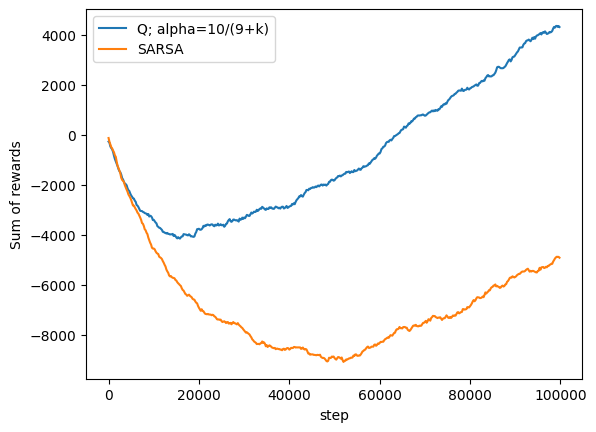

In [20]:
random.seed(321)

mon_env = Monster_game_env()

mag1 = Q_learner(mon_env.name, mon_env.actions, 0.9,
                     method="alpha=0.2")
#Simulate(mag1,mon_env).start().go(100000).plot()


mag_ucb = Q_learner(mon_env.name, mon_env.actions, 0.9,
                        exploration_strategy = ucb, es_kwargs={'c':0.1}, method="UCB(0.1),alpha=0.2")
#Simulate(mag_ucb,mon_env).start().go(100000).plot()


mag2 = Q_learner(mon_env.name, mon_env.actions, 0.9,
                     alpha_fun=lambda k:1/k,method="alpha=1/k")
#Simulate(mag2,mon_env).start().go(100000).plot()


mag3 = Q_learner(mon_env.name, mon_env.actions, 0.9,
                     alpha_fun=lambda k:10/(9+k), method="Q; alpha=10/(9+k)")
Simulate(mag3,mon_env).start().go(100000).plot()

mag3_1 = SARSA(mon_env.name, mon_env.actions, 0.9,
                     alpha_fun=lambda k:10/(9+k), method="S; alpha=10/(9+k)")
Simulate(mag3_1,mon_env).start().go(100000).plot()


mag4 = Q_learner(mon_env.name, mon_env.actions, 0.9,
                 alpha_fun=lambda k:10/(9+k),
                 exploration_strategy = ucb, es_kwargs={'c':0.1},
                 method="ucb & alpha=10/(9+k)")
#Simulate(mag4,mon_env).start().go(100000).plot()


# RL with Generalization

- Alternative to reasoning explicitly in terms of states
- Reason in terms of features, which can either be provided explicitly or learned
- Generic reinforcement on-policy learner that incorporates a supervised learner
- The learner carries out the following operations
    - *add(x,y)* which adds a new example to the dataset, with input $x$ and target value $y$
    - *predict(x)* which gives a point prediction for the target for an example with input $x$
- In the following, the input $x$ for the learner is a *state-action* pair, and the target for pair $(s,a)$ is an estimate of $Q^*(s,a)$

![](figs_rl/fig06.png)

# SARSA with Linear Function Approximation

- A linear function of features for the state and the action
- Require more information about the domain in terms of features
- Based on incremental gradient descent that updates the parameters after every example
- Suppose $F_1, ..., F_n$ are numerical features of the state and the action
    - $F_i(s,a)$ provides the value for the $i^{th}$ feature for state *s* and action *a*
- Used in representing the linear Q-function

$$
  Q_{\bar{w}}(s,a) = w_0 + w_1 * F_1(s,a) + ... + w_n * F_n(s,a)
$$

for some tuple of weights $\bar{w} = ⟨w_0,w_1,…,w_n⟩$ that have to be learned 

- An experience in SARSA of the form ⟨s,a,r,s',a'⟩ provides the new estimate $r + \gamma * Q_{\bar{w}}(s',a')$ to update $Q_{\bar{w}}(s,a)$
- used as a data point for **linear regression**
- Let $\delta = Q_{\bar{w}}(s,a) - (r + \gamma * Q_{\bar{w}}(s',a')$
- The weight $w_i$ is updated by
  $$
    w_i = w_i - \eta * \delta * F_i(s,a)
  $$

![](figs_rl/fig07.png)